In [1]:
import optical_gating_analysis as OG
import matplotlib.pyplot as plt
import numpy as np
import j_py_sad_correlation as jps

from scipy.signal import find_peaks
from scipy import signal

import tifffile as tf

In [2]:
data_src = r"E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\Allied Vision Technologies GS650 0001f61c\*tif"
ref_src = r"E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\ref-frames-2024-04-26-17.29.51\150456.tif"
ref_period = 73.106274
oog2 = OG.BasicOpticalGating()
oog2.sequence_manager.set_source(data_src)
oog2.sequence_manager.set_reference_sequence(ref_src)
oog2.sequence_manager.reference_period = ref_period
oog2.settings["pi_space"] = False
oog2.settings["normalise_sad"] = True
oog2.run()

Setting source to E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\Allied Vision Technologies GS650 0001f61c\*tif
Loading reference sequence from E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\ref-frames-2024-04-26-17.29.51\150456.tif
Getting SADs
Getting phases


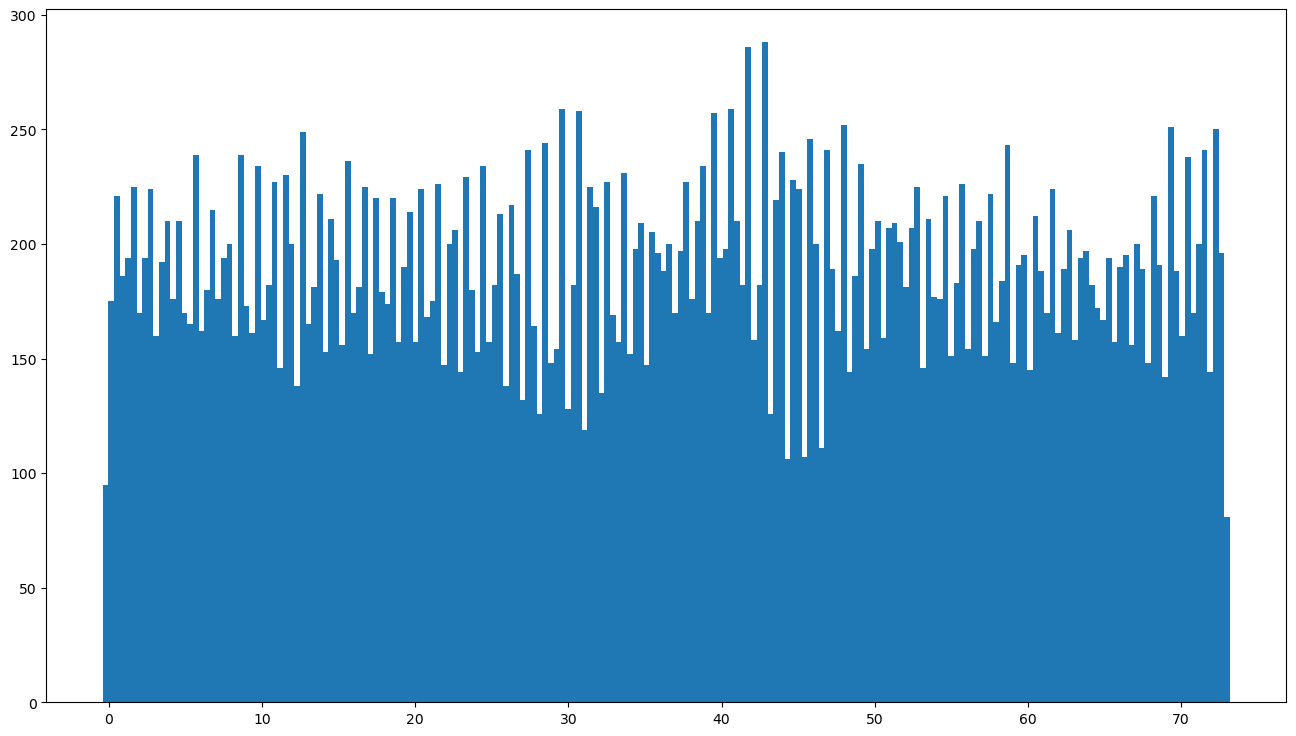

In [3]:
plt.figure(figsize = (16,9))
plt.hist(oog2.phases, bins = 200)
plt.show()

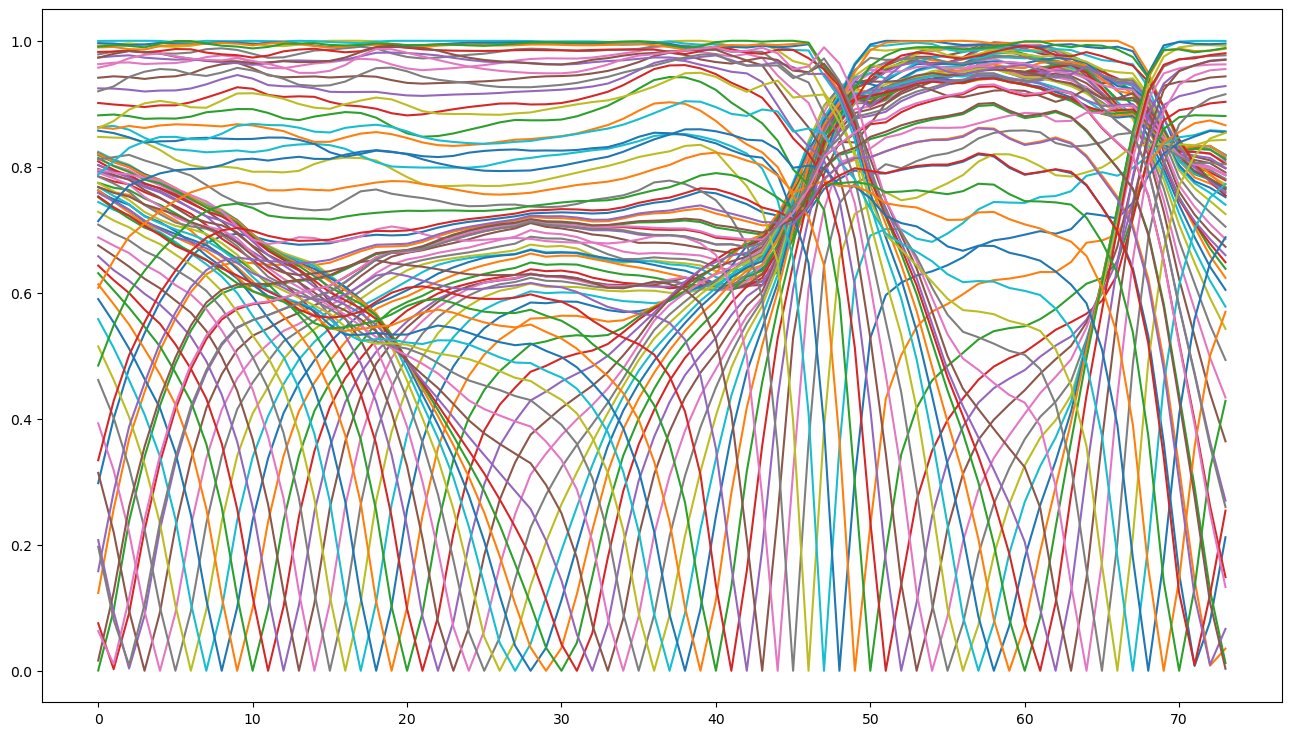

In [4]:
analyser = OG.BasicOpticalGating()
analyser.settings["pi_space"] = False

# Get mean sads for each frame
sads = []
counts = []
for i in range(2, oog2.sequence_manager.reference_sequence.shape[0] - 2):
    locs = np.where(np.array(oog2.frame_minimas) == i)[0]
    counts.append(len(locs))
    sads.append(np.mean(np.array(oog2.sads)[locs], axis = 0))

phases = []
for sad in sads:
    phases.append(analyser.get_phase(sad)[0])


plt.figure(figsize = (16,9))
plt.plot(sads)
plt.show()

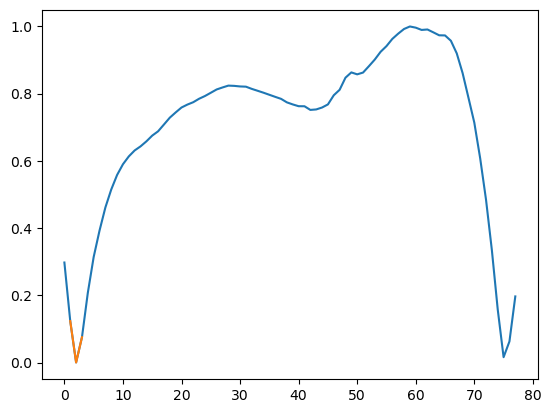

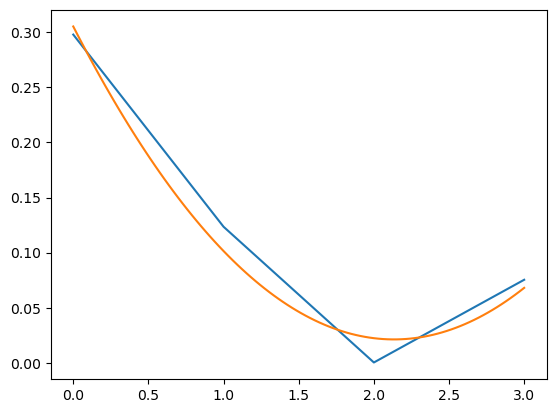

[0.02534852 0.02065295]


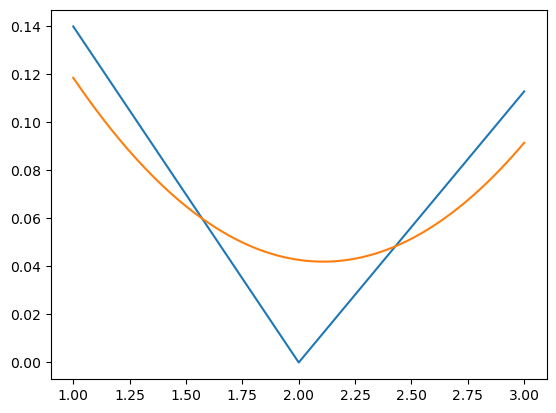

In [5]:
plt.plot(sads[0])
minima = np.argmin(sads[0][2:-2]) + 2

plt.plot(range(minima - 1, minima + 2), sads[0][minima - 1:minima + 2])
plt.show()

# Do quadratic fit around minimum
def quadratic_fit(x, a, b, c):
    return a * x**2 + b *x + c

from scipy.optimize import curve_fit

x = np.arange(minima - 2, minima + 2)
y = sads[0][minima - 2:minima + 2]

popt, pcov = curve_fit(quadratic_fit, x, y)

xs = np.linspace(minima - 2, minima + 1, 100)

plt.plot(x, y)
plt.plot(xs, quadratic_fit(xs, *popt))
plt.show()


sad = oog2.sads[280]
minima = np.argmin(sad[2:-2]) + 2

x = np.arange(minima - 1, minima + 2)
y = sad[minima - 1:minima + 2]
plt.plot(x,y)

a, b, c = popt

def fit(x, x_offset, y_offset):
    return quadratic_fit(x + x_offset, a, b, c) + y_offset

popt, pcov = curve_fit(fit, x, y)
print(popt)
x = np.linspace(minima - 1, minima + 1, 100)
plt.plot(x, fit(x, *popt))
plt.show()

In [6]:
order = np.argsort(oog2.phases)

In [7]:
print(np.array(oog2.sads).shape)

(37970, 78)


In [8]:
ordered_sads = np.array(oog2.sads)[order]


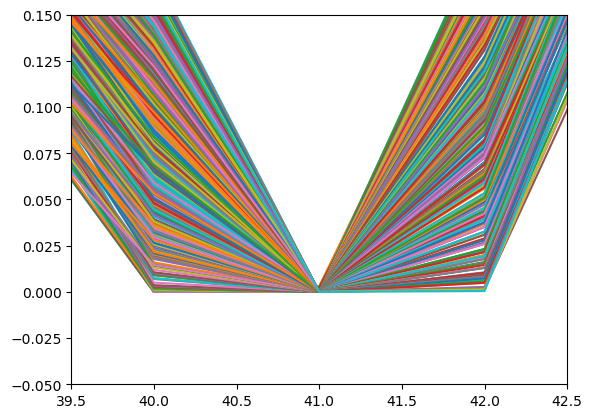

In [9]:
plt.plot(ordered_sads[19880:20450].transpose())
plt.xlim(39.5,42.5)
plt.ylim(-0.05, 0.15)
plt.show()

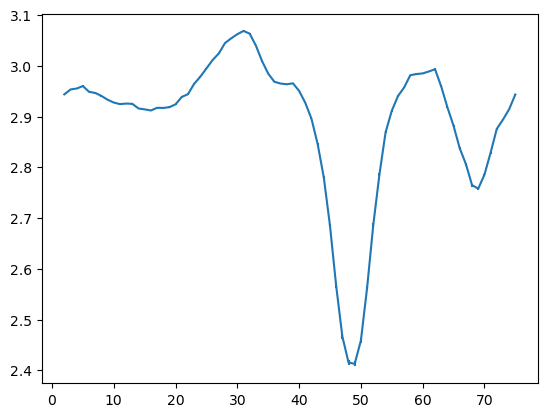

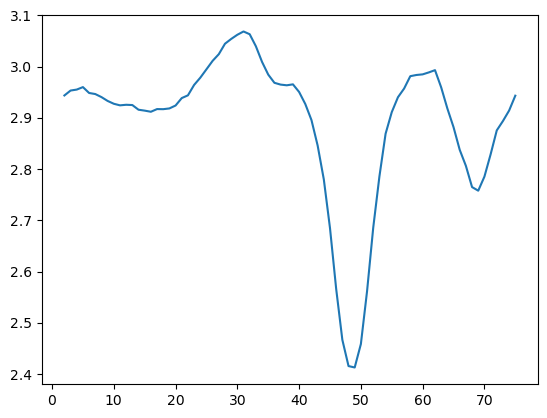

In [10]:
minima = 70

mean_minimas = []
std_minimas = []
for minima in range(2, oog2.sequence_manager.reference_sequence.shape[0] - 2):
    angles_between = []
    for index in np.where(oog2.frame_minimas == minima)[0]:
        # Get sad minimas
        sad_l = np.array(oog2.sads[index])[minima - 1]
        sad_r = np.array(oog2.sads[index])[minima + 1]
        angle_between = np.pi - (np.arctan(sad_r) + np.arctan(sad_l))
        angles_between.append(angle_between)

    mean_minimas.append(np.mean(angles_between))
    std_minimas.append(np.std(angles_between) / np.sqrt(len(angles_between)))

    """plt.hist(angles_between, bins = 100)
    plt.show()"""

# Plot mean minimas with errorbars
plt.errorbar(range(2, oog2.sequence_manager.reference_sequence.shape[0] - 2), mean_minimas, yerr = std_minimas)
plt.show()

# Plot mean minimas
plt.plot(range(2, oog2.sequence_manager.reference_sequence.shape[0] - 2), mean_minimas)
plt.show()

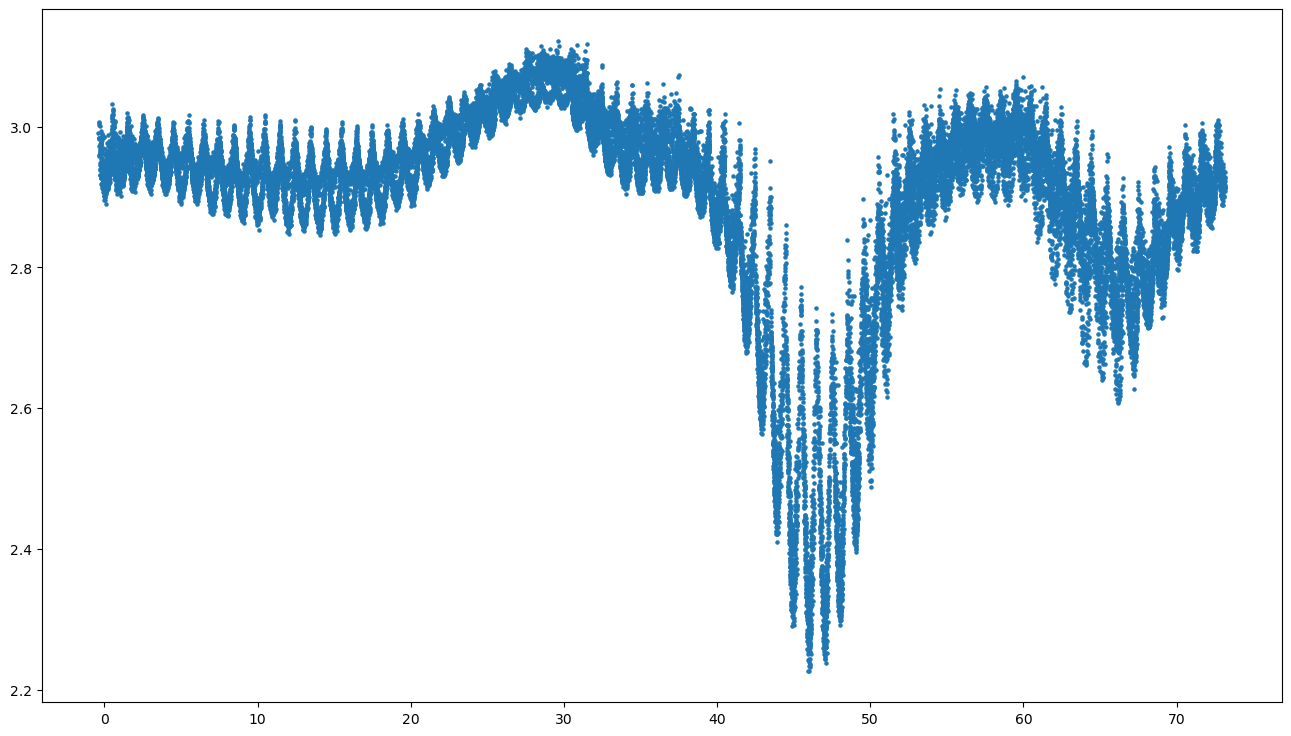

In [11]:
# Get angles between minimas
minima = 70

angles_between = []
phases = []
for minima in range(2, oog2.sequence_manager.reference_sequence.shape[0] - 2):
    for index in np.where(oog2.frame_minimas == minima)[0]:
        # Get sad minimas
        sad_l = np.array(oog2.sads[index])[minima - 1]
        sad_r = np.array(oog2.sads[index])[minima + 1]
        angle_between = np.pi - (np.arctan(sad_r) + np.arctan(sad_l))
        angles_between.append(angle_between)
        phases.append(oog2.phases[index])

plt.figure(figsize = (16,9))
plt.scatter(phases, angles_between, s = 5)
plt.show()

(78, 535)


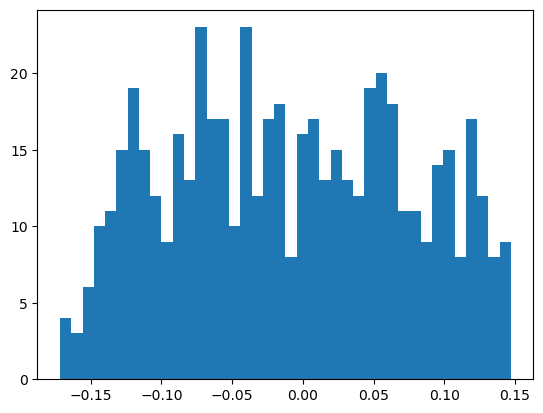

In [12]:
minima = 40

sads = np.array(oog2.sads)[np.where(oog2.frame_minimas == minima)].transpose()

print(sads.shape)
plt.hist(sads[minima - 1][:] - sads[minima + 1][:], bins = 40)
plt.show()

plt.show()

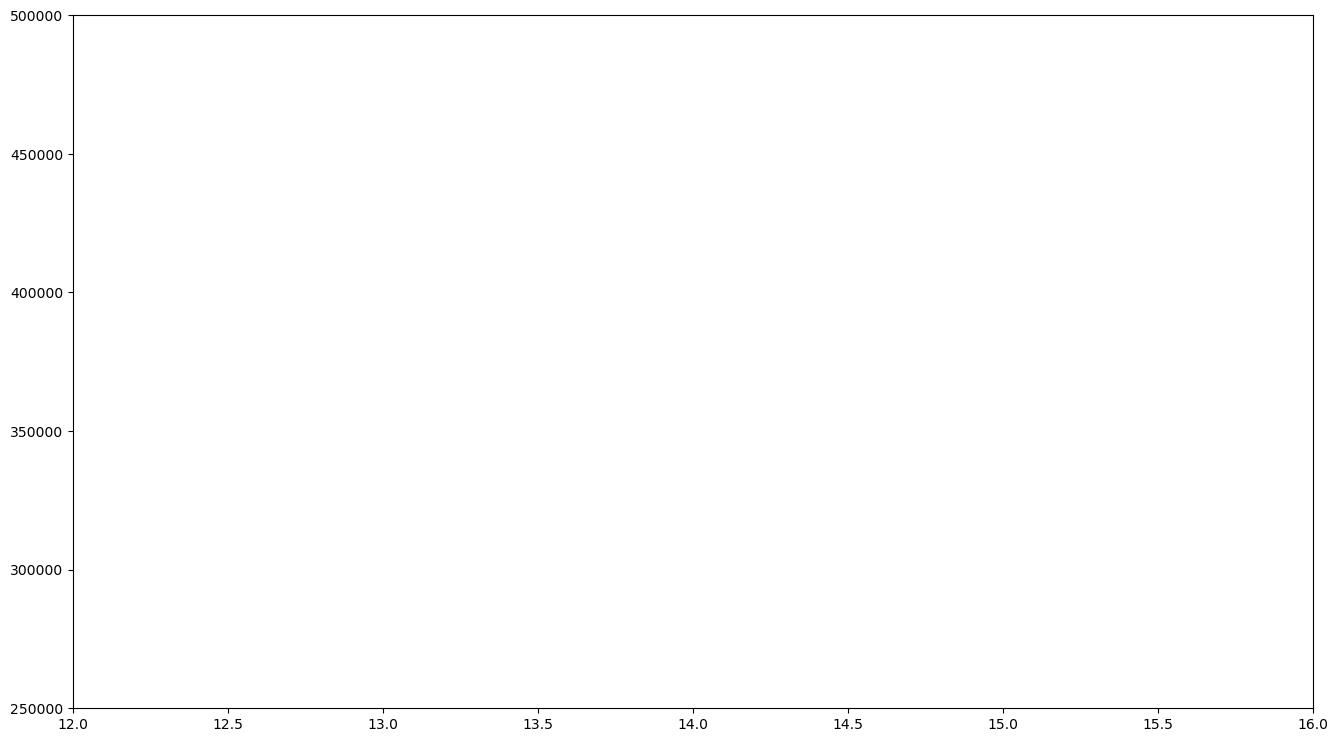

In [13]:
"""plt.plot(np.array(oog2.sads)[order][2000:2500].transpose())
plt.xlim(0,10)
plt.ylim(-0.1, 0.2)
plt.show()"""


plt.figure(figsize = (16,9))
for i in range(6080, 6600):
    plt.plot(ordered_sads[i], lw = 0.5)

plt.xlim(12,16)
plt.ylim(250000, 500000)

plt.show()